In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [176]:
deep_reload(nice)

# rng = np.random.default_rng(26893751)
rng = np.random.default_rng()

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
}

atlas = nice.graph.nmu_graph(100, 3, **kw)

conditions = [
    lambda e: e['distance'] <= 300e3,
    lambda e: e['distance'] >= 100e3,
]

# graph = nice.graph.all_pairs_graph(atlas, conditions, simple = False)
graph = atlas

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']
        edge['capacity'] = 1

print(graph_o.number_of_nodes(), graph_o.number_of_edges())

# fig, ax = plt.subplots()

# _ = nice.plot.plot_graph(graph, nodes = {}, edges = {}, ax = ax)

100 10000


In [177]:
deep_reload(nice)

n = 1

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)

level_graph = nice.graph.level_graph(graph, places[0], objective = 'time')

print(level_graph.number_of_nodes(), level_graph.number_of_edges())

100 437


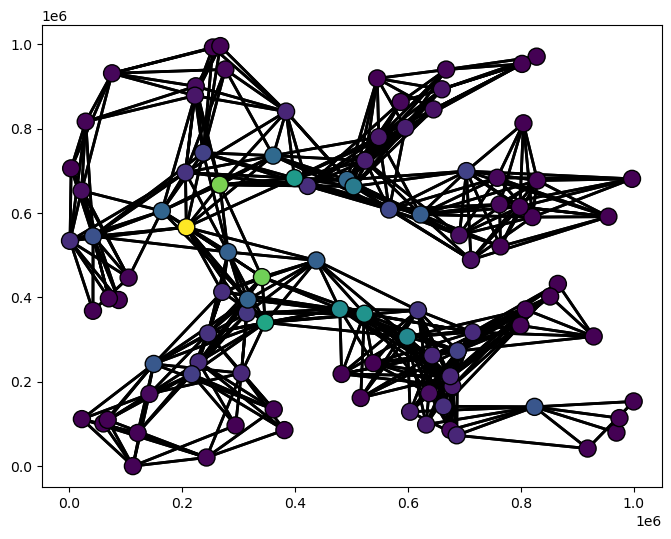

In [178]:
deep_reload(nice)

pc = nx.percolation_centrality(graph)

for source, node in graph._node.items():

    node['p'] = pc[source]

fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'nodes': {
        'field': 'p',
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
        },
    },
    'edges': {
        'plot': {
            'lw': 2,
            'color': 'k',
            'zorder': 1,
        },
    },
}
    
sm = nice.plot.plot_graph(graph, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'color': 'gray',
            'zorder': 0,
        },
    },
}
    
# sm = nice.plot.plot_graph(graph, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list([places[0]]),
        'plot': {
            's': 150,
            'c': 'g',
            'zorder': 3,
            'ec': 'k',
        },
    },
}
    
# sm = nice.plot.plot_graph(level_graph, ax = ax, **kw)

In [140]:
level_graph.__class__

networkx.classes.digraph.DiGraph

In [145]:
from itertools import islice

# graph = nx.cycle_graph(7)

origin = places[0]
destination = rng.choice(level_graph.nodes, replace = False, size = n)[0]

path_gen = nx.shortest_simple_paths(level_graph, origin, destination, weight = 'time')

def get_path_cost(graph, path, weight = ''):

    _adj = graph._adj
    
    cost = 0
    
    for idx in range(1, len(path)):
    
        source = path[idx - 1]
        target = path[idx]
        
        cost += _adj[source][target].get(weight, 1)
    
    return cost

def limit_paths(graph, path_gen, ratio, weight = ''):

    # shortest_path = next(path_gen)
    # shortest_path_cost = get_path_cost(graph, shortest_path, weight) 
    
    # paths = [shortest_path]
    
    # for path in path_gen:
    
    #     path_cost = get_path_cost(graph, path, weight = weight)

    #     print(path_cost / shortest_path_cost, end = '\r')
        
    #     if path_cost > shortest_path_cost * ratio:
        
    #         break

    #     paths.append(path)

    paths = list(islice(path_gen, 100))
    
    return paths

paths = limit_paths(level_graph, path_gen, 2, weight = 'time')
len(paths)

2

In [135]:
len(paths)

3

In [158]:
n = 10

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)

origin = places[0]
destinations = stations = list(set(places) - set([origin]))

level_graph = nice.graph.level_graph(graph, origin, objective = 'time')

paths = {}

for destination in places:

    path_gen = nx.shortest_simple_paths(level_graph, origin, destination, weight = 'time')

    paths[destination] = list(islice(path_gen, 20))
# len(paths)

In [179]:
paths.get(None, 1)

1

In [4]:
'''
Preparing the graph
'''
deep_reload(nice)

graph = graph_o.copy()

n = 1

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)
stations = list(set(graph.nodes) - set(places))

nodes = []
edges = []

m = graph.number_of_nodes()

for place in places:

    m += 1
    node = graph._node[place]
    
    nodes.append((m, node))
    stations.append(m)

    for p in graph.predecessors(place):

        edges.append((p, m, graph._adj[p][place]))

    for s in graph.successors(place):

        edges.append((m, s, graph._adj[place][s]))

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

'''
Adding classes
'''

for place in places:

    graph._node[place]['_class'] = 'Place'

'''
Adding Delay
'''

energy = 35 * 3.6e6
power = 80e3

m = 1 / (energy / power)
rho = np.linspace(0, 1, 10)
c = np.arange(1, 11, 1)

queue = nice.queue.Queue(m = m, bounds = (0, 24 * 3600))

for station in stations:

    station_c = rng.choice(c)

    volumes = rho * m * station_c
    delays = queue.interpolate(rho, station_c)

    graph._node[station]['_class'] = 'Station'
    graph._node[station]['volumes'] = volumes
    graph._node[station]['delays'] = delays * volumes / 3600
    

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = 'Path'

'''
Adding demands
'''
for place in places:

    destinations = set(places) - set([place])

    demands = rng.uniform(0, 1, size = len(destinations))
    demands /= demands.sum()

    graph._node[place]['demand'] = {p: demands[i] for i, p in enumerate(destinations)}
    # break

'''
Adding time to links
'''
for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']
        edge['ac_time'] = edge['distance'] / 20 * 3600 + edge['time']

'''
Making direct path links
'''
for origin in places:

    path = nx.shortest_path(graph, source = origin, weight = 'ac_time')

    for destination in places:

        costs = nice.graph.path_cost(
            graph, path[destination], fields = ['distance', 'ac_time']
        )
        
        costs['time'] = costs['ac_time']
        costs['direct'] = True
        
        graph.add_edge(origin, destination, **costs, _class = 'Path')
        
print(graph.number_of_nodes(), graph.number_of_edges())

80 5500


In [5]:
deep_reload(nice)

lg = nice.optimization.level_graph(
    graph, places[0], objective = 'distance', destinations = places
)

lg.number_of_nodes(), lg.number_of_edges()

(80, 1557)

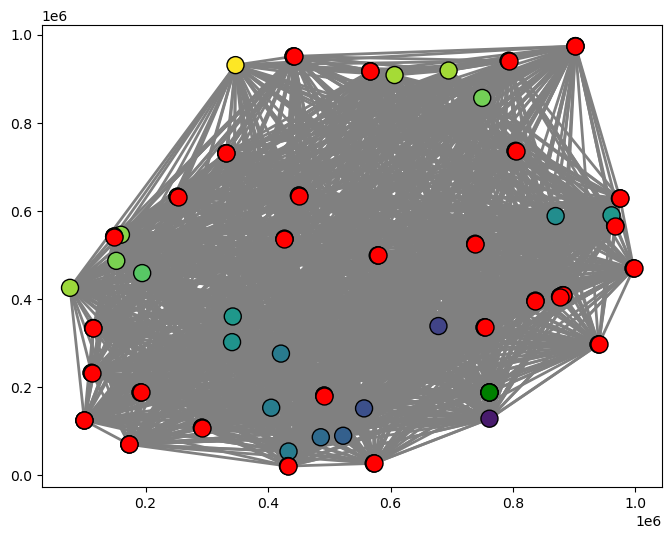

In [6]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'nodes': {
        'field': 'cost',
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
        },
    },
    'edges': {
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
sm = nice.plot.plot_graph(lg, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 150,
            'c': 'r',
            'zorder': 3,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(lg, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list([places[0]]),
        'plot': {
            's': 150,
            'c': 'g',
            'zorder': 3,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(lg, ax = ax, **kw)